In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
# downloading the data
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

In [3]:
def fetch_housing_data(housing_url = HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path,"housing.tgz")
    urllib.request.urlretrieve(housing_url,tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
fetch_housing_data()

In [5]:
# loading the data
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

In [6]:
housing = load_housing_data()

### Plotting numerical data and understanding the dataset

In [7]:
# first 5 data
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [8]:
# shows general information about the dataset i.e., count and type
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


missing data on total_bedrooms

In [9]:
# checking categorical data
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [10]:
# show a general idea of the data inside the dataset
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


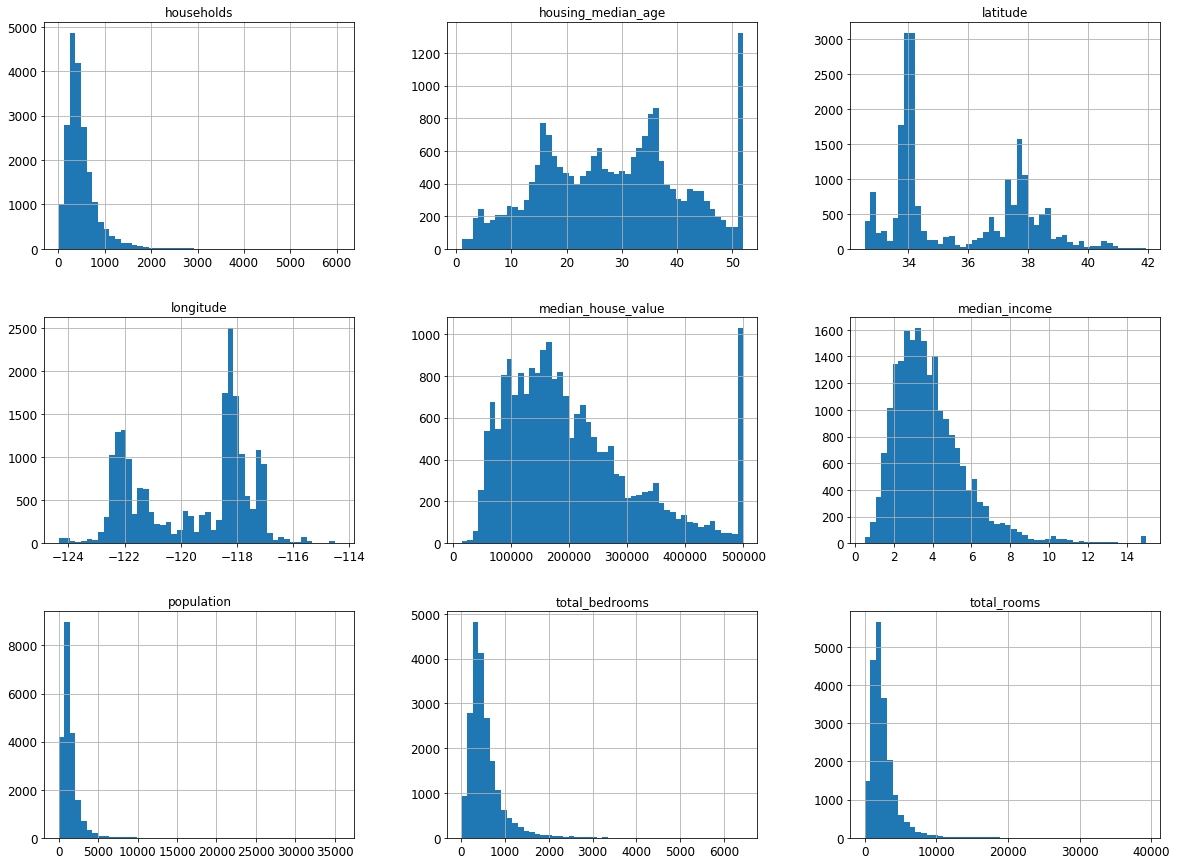

In [11]:
# plotting of numerical data and distribution
import matplotlib.pyplot as plt
housing.hist(bins=50,figsize=(20,15))
plt.show()

In [12]:
import numpy as np

### Creating a test set

In [13]:
# primitive form of splitting the data into a test set

def split_train_test(data,test_ratio):
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)* test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [14]:
train_set,test_set=split_train_test(housing,0.2)

In [15]:
 print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


In [16]:
# creates a hash identifier for the dataset
# takes in the last byte of the hash
# and uses it as identifier

from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

#### Create unique id classifier

In [17]:
# splits into training and testing data with the use of hash identifier
# which in return, the new test set will contain 20% of the new instance
# but will not contain any instance from the previous instance in the training set.

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [18]:
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id,0.2,"index")

In [19]:
housing_with_id['id'] = housing['longitude']*1000 + housing['latitude']
train_set, test_set = split_train_test_by_id(housing_with_id,0.2,"id")

In [20]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
59,59,-122.29,37.82,2.0,158.0,43.0,94.0,57.0,2.5625,60000.0,NEAR BAY,-122252.18
60,60,-122.29,37.83,52.0,1121.0,211.0,554.0,187.0,3.3929,75700.0,NEAR BAY,-122252.17
61,61,-122.29,37.82,49.0,135.0,29.0,86.0,23.0,6.1183,75000.0,NEAR BAY,-122252.18
62,62,-122.29,37.81,50.0,760.0,190.0,377.0,122.0,0.9011,86100.0,NEAR BAY,-122252.19
67,67,-122.29,37.80,52.0,1027.0,244.0,492.0,147.0,2.6094,81300.0,NEAR BAY,-122252.20


In [21]:
train_set, test_set = split_train_test_by_id(housing_with_id,0.2,'id')

In [22]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
housing['income_cat'] = np.ceil(housing['median_income']/1.5)
housing['income_cat'].where(housing['income_cat']<5, 5.0,inplace=True)


In [23]:
housing['income_cat'].value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

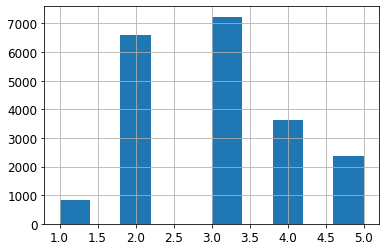

In [24]:
housing['income_cat'].hist()

> **Remember:** It is important to have a sufficient number of instances in your dataset for each stratum, or else the estimate of the stratum’s importance may be biased

In [25]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [26]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [27]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [28]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1.0,0.039826,0.039729,0.040213,0.973236,-0.243309
2.0,0.318847,0.318798,0.324370,1.732260,-0.015195
3.0,0.350581,0.350533,0.358527,2.266446,-0.013820
4.0,0.176308,0.176357,0.167393,-5.056334,0.027480
5.0,0.114438,0.114583,0.109496,-4.318374,0.127011


In [29]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [30]:
housing = strat_train_set.copy()

### Visualizing Data

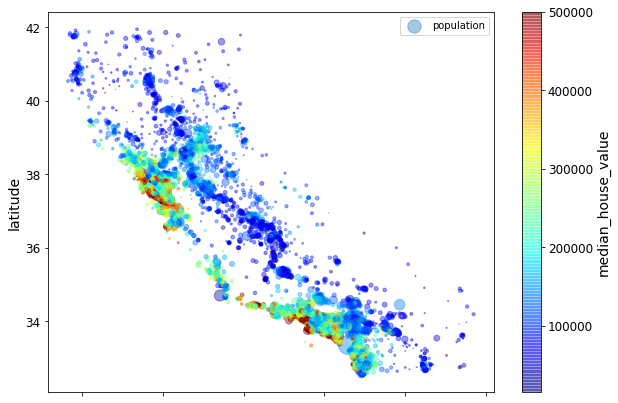

In [31]:
housing.plot(kind='scatter',x='longitude', y='latitude',
             alpha=0.4, s=housing['population']/100,label='population',c='median_house_value',
             cmap=plt.get_cmap('jet'), colorbar=True, figsize=(10,7) )

In [32]:
corr_matrix = housing.corr()

In [33]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

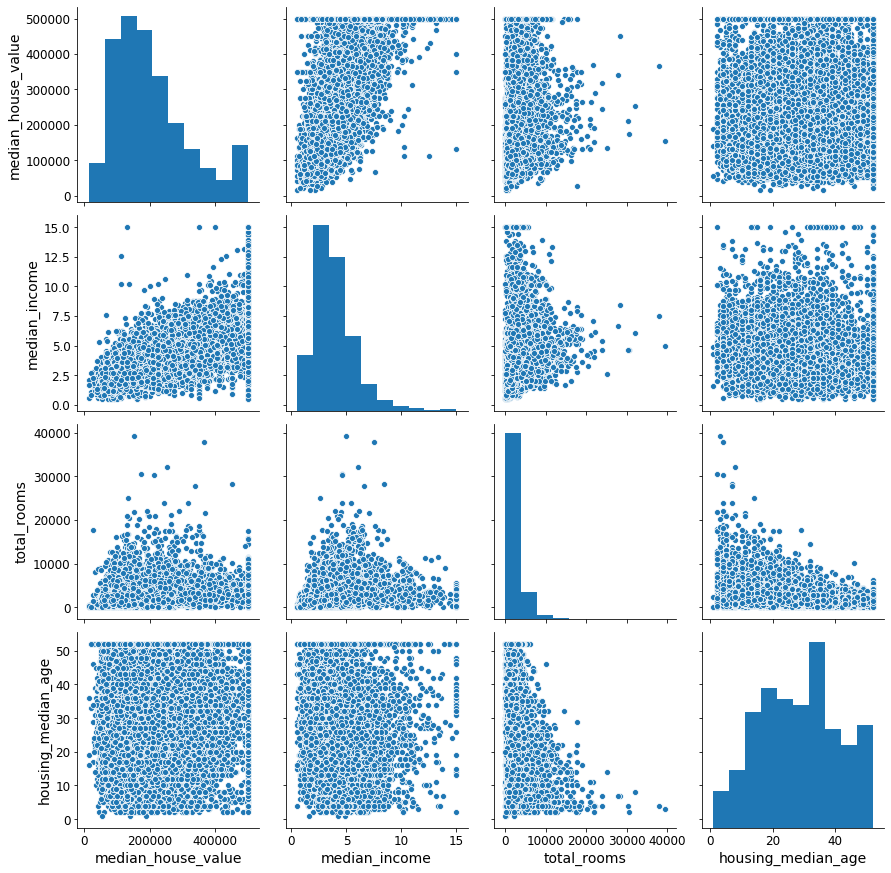

In [34]:
sns.pairplot(housing[["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]], height=3)

#save_fig("scatter_matrix_plot")

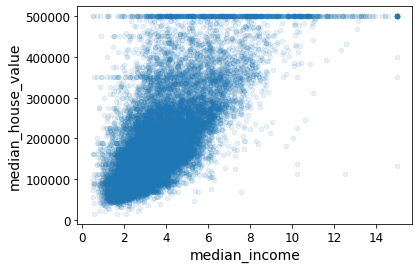

In [35]:
housing.plot(kind='scatter', x='median_income', y='median_house_value',alpha=0.1)

In [36]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedroom_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

In [37]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedroom_per_room           -0.259984
Name: median_house_value, dtype: float64

In [38]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [39]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN


### Preparing the Data

Scikit-Learn provides a handy class to take care of missing values: **Imputer**.

In [40]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

> Result of the impute; the median values of the missing data

In [41]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [42]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

>Now you can use this “trained” imputer to transform the training set by replacing missing values by the learned medians:

In [43]:
X = imputer.transform(housing_num)

In [44]:
# conversion into dataframe of numpy array
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

### Handling Text and Categorical Attributes

> Convert Categorical Text Attributes into labels(numerical values)

In [45]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
housing_cat = housing['ocean_proximity']
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3])

In [46]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     7276
INLAND        5263
NEAR OCEAN    2124
NEAR BAY      1847
ISLAND           2
Name: ocean_proximity, dtype: int64

In [47]:
print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


In [48]:
from sklearn.preprocessing import OneHotEncoder

> convert the caterogrical data into an encoder

In [49]:
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [50]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [51]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = [
    list(housing.columns).index(col)
    for col in ("total_rooms", "total_bedrooms", "population", "households")]

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self,add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self,X,y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room= X[:,bedrooms_ix]/ X[:,rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, 
                        bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]


In [52]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

### Pipelines

> The Pipeline constructor takes a list of name/estimator pairs defining a sequence of steps. All but the last estimator must be transformers (i.e., they must have a fit_transform() method). The names can be anything you like.

> **When you call the pipeline’s fit() method, it calls fit_transform() sequentially onball transformers, passing the output of each call as the parameter to the next call, until it reaches the final estimator, for which it just calls the fit() method.**

In [53]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())])

In [54]:
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [55]:
try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer

In [56]:
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [57]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [58]:
housing_prepared.shape

(16512, 16)

### Select and train a model

In [59]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [60]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

In [61]:
print("Predictions:\t", np.around(lin_reg.predict(some_data_prepared),2))

Predictions:	 [210644.6  317768.81 210956.43  59218.99 189747.56]


In [62]:
print("Labels:\t\t", list(some_labels))

Labels:		 [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [63]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

In [64]:
lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49439.89599001897

In [65]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [93]:
from sklearn.svm import SVR

svm_reg = SVR(kernel='linear')
svm_reg.fit(housing_prepared, housing_labels)

housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels,housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111094.6308539982

### Validating the model

In [66]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared,housing_labels,
                        scoring = 'neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [67]:
def display_scores(scores):
    print('Scores: ', scores)
    print('Mean: ', scores.mean())
    print('Standard Deviation: ', scores.std())

In [68]:
display_scores(tree_rmse_scores)

Scores:  [69327.01708558 65486.39211857 71358.25563341 69091.37509104
 70570.20267046 75529.94622521 69895.20650652 70660.14247357
 75843.74719231 68905.17669382]
Mean:  70666.74616904806
Standard Deviation:  2928.322738055112


In [69]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                            scoring = 'neg_mean_squared_error', cv=10)

In [70]:
lin_rmse_scores = np.sqrt(-lin_scores)

In [71]:
display_scores(lin_rmse_scores)

Scores:  [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean:  69052.46136345083
Standard Deviation:  2731.674001798349


In [72]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [73]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

21933.31414779769

In [74]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                    scoring='neg_mean_squared_error',cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores:  [51646.44545909 48940.60114882 53050.86323649 54408.98730149
 50922.14870785 56482.50703987 51864.52025526 49760.85037653
 55434.21627933 53326.10093303]
Mean:  52583.72407377466
Standard Deviation:  2298.353351147122


### Pickling and saving data

In [75]:
#from sklearn.externals import joblib
#joblib.dump(my_model, 'my_model.pkl')
# my_model_loaded = joblib.load('my_model.pkl')

### Fine Tuning and Grid Search

In [76]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3,10,30], 'max_features':[2,4,6,8]},
    {'bootstrap':[False], 'n_estimators': [3,10], 'max_features':[2,3,4]}
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg,param_grid,cv=5,
                          scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared,housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [77]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [78]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [79]:
cvres = grid_search.cv_results_

In [80]:
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score),params)

63753.5461528816 {'max_features': 2, 'n_estimators': 3}
56152.21937257319 {'max_features': 2, 'n_estimators': 10}
52795.21689339568 {'max_features': 2, 'n_estimators': 30}
60451.094331092594 {'max_features': 4, 'n_estimators': 3}
53192.357091620055 {'max_features': 4, 'n_estimators': 10}
50502.27548914166 {'max_features': 4, 'n_estimators': 30}
59451.09352442982 {'max_features': 6, 'n_estimators': 3}
52024.08066167432 {'max_features': 6, 'n_estimators': 10}
49977.58768754372 {'max_features': 6, 'n_estimators': 30}
58376.64679593403 {'max_features': 8, 'n_estimators': 3}
52089.93695027458 {'max_features': 8, 'n_estimators': 10}
50309.329963579 {'max_features': 8, 'n_estimators': 30}
62494.38975288301 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54586.08947518622 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60092.32083232561 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52607.240151793594 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10

In [94]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
    'n_estimators': randint(low=1,high=200),
    'max_features': randint(low=1,high=8)
}

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                               n_iter=10,cv=5,scoring='neg_mean_squared_error',
                               random_state=42)
rnd_search.fit(housing_prepared,housing_labels)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [96]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'],cvres['params']):
    print(np.sqrt(-mean_score),params)

49150.70756927707 {'max_features': 7, 'n_estimators': 180}
51389.889203389284 {'max_features': 5, 'n_estimators': 15}
50796.155224308866 {'max_features': 3, 'n_estimators': 72}
50835.13360315349 {'max_features': 5, 'n_estimators': 21}
49280.9449827171 {'max_features': 7, 'n_estimators': 122}
50774.90662363929 {'max_features': 3, 'n_estimators': 75}
50682.78888164288 {'max_features': 3, 'n_estimators': 88}
49608.99608105296 {'max_features': 5, 'n_estimators': 100}
50473.61930350219 {'max_features': 3, 'n_estimators': 150}
64429.84143294435 {'max_features': 5, 'n_estimators': 2}


In [97]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.88085467e-02, 7.33496388e-02, 4.09954065e-02, 1.67091258e-02,
       1.73554988e-02, 1.77318205e-02, 1.59227275e-02, 3.07956727e-01,
       5.38513930e-02, 1.10407460e-01, 9.81576768e-02, 7.59214979e-03,
       1.53346255e-01, 9.45085982e-05, 2.55826347e-03, 5.16280248e-03])

In [103]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attribute = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances,attributes),reverse=True)

[(0.30795672652438416, 'median_income'),
 (0.15334625523523016, 'INLAND'),
 (0.11040745956098118, 'pop_per_hhold'),
 (0.09815767677490277, 'bedrooms_per_room'),
 (0.07880854666610768, 'longitude'),
 (0.07334963881963506, 'latitude'),
 (0.053851393042369335, 'rooms_per_hhold'),
 (0.040995406457984815, 'housing_median_age'),
 (0.017731820497973446, 'population'),
 (0.017355498758235867, 'total_bedrooms'),
 (0.016709125785504313, 'total_rooms'),
 (0.0159227275319888, 'households'),
 (0.007592149789429611, '<1H OCEAN'),
 (0.005162802483529534, 'NEAR OCEAN'),
 (0.002558263473579651, 'NEAR BAY'),
 (9.450859816373917e-05, 'ISLAND')]

In [104]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

48078.53091897726

### Analyzing the Best Models and Their errors

In [81]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.88085467e-02, 7.33496388e-02, 4.09954065e-02, 1.67091258e-02,
       1.73554988e-02, 1.77318205e-02, 1.59227275e-02, 3.07956727e-01,
       5.38513930e-02, 1.10407460e-01, 9.81576768e-02, 7.59214979e-03,
       1.53346255e-01, 9.45085982e-05, 2.55826347e-03, 5.16280248e-03])

In [82]:
extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse =True)

[(0.30795672652438416, 'median_income'),
 (0.15334625523523016, 'INLAND'),
 (0.11040745956098118, 'pop_per_hhold'),
 (0.09815767677490277, 'bedrooms_per_room'),
 (0.07880854666610768, 'longitude'),
 (0.07334963881963506, 'latitude'),
 (0.053851393042369335, 'rooms_per_hhold'),
 (0.040995406457984815, 'housing_median_age'),
 (0.017731820497973446, 'population'),
 (0.017355498758235867, 'total_bedrooms'),
 (0.016709125785504313, 'total_rooms'),
 (0.0159227275319888, 'households'),
 (0.007592149789429611, '<1H OCEAN'),
 (0.005162802483529534, 'NEAR OCEAN'),
 (0.002558263473579651, 'NEAR BAY'),
 (9.450859816373917e-05, 'ISLAND')]

In [83]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test,final_predictions)
final_rmse = np.sqrt(final_mse)

In [84]:
final_rmse

48078.53091897726

### Confidence Intervals

In [109]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test)**2
mean = squared_errors.mean()
m = len(squared_errors)

np.sqrt(stats.t.interval(confidence, m-1,
                        loc = np.mean(squared_errors),
                        scale = stats.sem(squared_errors)))

array([46075.38723719, 50001.48959379])

# Exercises

## 1.

In [118]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000.]},
    {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300.],
    'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
]
svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, 
                           scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search.fit(housing_prepared,housing_labels)

Fitting 5 folds for each of 43 candidates, totalling 215 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  8.9min
[Parallel(n_jobs=4)]: Done 215 out of 215 | elapsed: 12.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=4,
             param_grid=[{'C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0,
                                10000.0],
                          'kernel': ['linear']},
                         {'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0],
                          'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=2)

In [119]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

70374.76833985467

In [120]:
grid_search.best_params_

{'C': 10000.0, 'kernel': 'linear'}

## 2.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

param_distribs = {
    'kernel': ['linear','rbf'],
    'C': reciprocal(20,200000),
    'gamma': expon(scale=1.0)
}

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                               n_iter=50,cv=5,scoring='neg_mean_squared_error',
                               random_state=42)
rnd_search.fit(housing_prepared,housing_labels)